# Basic regression: Predict fuel efficiency

### Statement:
In a regression problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic Auto MPG dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']


In [5]:
raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
raw_dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [16]:
dataset = raw_dataset.copy()
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


# Cleaning data

In [17]:
dataset.isna().sum()  # QC missing values

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [18]:
dataset = dataset.dropna()  # drop na rows
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [19]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


In [10]:
dataset["Origin"] = dataset.Origin.map({1:"USA",2:"Europe",3:"Japan"})  # origin is categorical and not numerical
dataset.head(25)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA
5,15.0,8,429.0,198.0,4341.0,10.0,70,USA
6,14.0,8,454.0,220.0,4354.0,9.0,70,USA
7,14.0,8,440.0,215.0,4312.0,8.5,70,USA
8,14.0,8,455.0,225.0,4425.0,10.0,70,USA
9,15.0,8,390.0,190.0,3850.0,8.5,70,USA


In [11]:
set(dataset.Origin)

{'Europe', 'Japan', 'USA'}

In [12]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [13]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA


In [14]:
# categorical to numerical - pandas dummies

dataset = pd.get_dummies(dataset, columns = ["Origin"], prefix='', prefix_sep='')
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [15]:
# split data
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)  # creates test dataset by dropping the train dataset
train_dataset.shape, test_dataset.shape

((314, 10), (78, 10))

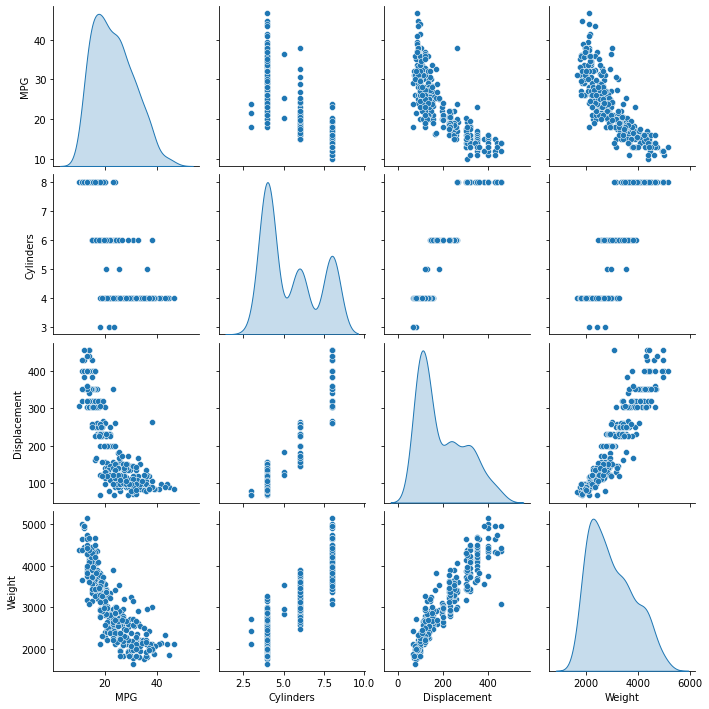

In [20]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind="kde")

* Fuel efficiency (MPG) is a function of all the other parameters

In [21]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


* Note how each feature covers a very different range:

In [24]:
train_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,28.0,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,22.3,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,12.0,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,38.0,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,33.8,4,97.0,67.0,2145.0,18.0,80,0,1,0


In [29]:
train_features = train_dataset[["Cylinders","Displacement","Horsepower","Weight","Acceleration","Model Year","Europe","Japan","USA"]].copy()
train_features

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [30]:
test_features = test_dataset[["Cylinders","Displacement","Horsepower","Weight","Acceleration","Model Year","Europe","Japan","USA"]].copy()
test_features

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
9,8,390.0,190.0,3850.0,8.5,70,0,0,1
25,8,360.0,215.0,4615.0,14.0,70,0,0,1
28,8,304.0,193.0,4732.0,18.5,70,0,0,1
31,4,113.0,95.0,2228.0,14.0,71,0,1,0
33,6,232.0,100.0,2634.0,13.0,71,0,0,1
...,...,...,...,...,...,...,...,...,...
369,4,112.0,88.0,2395.0,18.0,82,0,0,1
375,4,105.0,74.0,1980.0,15.3,82,1,0,0
382,4,108.0,70.0,2245.0,16.9,82,0,1,0
384,4,91.0,67.0,1965.0,15.7,82,0,1,0


In [33]:
train_labels = train_dataset['MPG'].copy()
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

In [34]:
test_labels = test_dataset['MPG'].copy()
test_labels

9      15.0
25     10.0
28      9.0
31     25.0
33     19.0
       ... 
369    34.0
375    36.0
382    34.0
384    32.0
396    28.0
Name: MPG, Length: 78, dtype: float64

In [35]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


* It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity.

### The Normalization layer
The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into your model.

In [36]:
train_features

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [37]:
np.array(train_features)

array([[  4.,  90.,  75., ...,   0.,   0.,   1.],
       [  4., 140.,  88., ...,   0.,   0.,   1.],
       [  8., 350., 160., ...,   0.,   0.,   1.],
       ...,
       [  4., 108.,  93., ...,   0.,   1.,   0.],
       [  4.,  83.,  61., ...,   0.,   1.,   0.],
       [  4., 107.,  86., ...,   1.,   0.,   0.]])

In [39]:
train_features[:1]

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1


In [40]:
first = np.array(train_features[:1])
first

array([[   4. ,   90. ,   75. , 2125. ,   14.5,   74. ,    0. ,    0. ,
           1. ]])

In [42]:

normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)       # create the layer
normalizer.adapt(np.array(train_features))   #fit the state of the preprocessing layer to the data by calling Normalization.adapt:
print(normalizer.mean.numpy())                            # Calculate the mean and variance, and store them in the layer:
first = np.array(train_features[:1])                      # array of the first row

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())         # it returns the input data, with each feature independently normalized:

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]
First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Linear regression
Before building a deep neural network model, start with linear regression using one and several variables.

### Linear regression with one variable
Begin with a single-variable linear regression to predict 'MPG' from 'Horsepower'.

Training a model with tf.keras typically starts by defining the model architecture. Use a tf.keras.Sequential model, which represents a sequence of steps.

### There are two steps in your single-variable linear regression model:

* Normalize the 'Horsepower' input features using the tf.keras.layers.Normalization preprocessing layer.

* Apply a linear transformation ( y=mx+b ) to produce 1 output using a linear layer (tf.keras.layers.Dense).
The number of inputs can either be set by the input_shape argument, or automatically when the model is run for the first time.

##  First, 
* create a NumPy array made of the 'Horsepower' features. Then, instantiate the tf.keras.layers.Normalization and fit its state to the horsepower data:

In [47]:
horsepower = np.array(train_features['Horsepower'])
horsepower

array([ 75.,  88., 160.,  63.,  67.,  90.,  60.,  67.,  95.,  88.,  60.,
       180.,  88., 150., 155.,  75., 115., 150.,  90.,  90., 129., 110.,
        90., 110.,  76., 165.,  92.,  88., 100., 150., 122.,  74.,  76.,
        67., 110.,  90.,  65., 150., 150., 220., 165.,  67.,  75., 140.,
        78., 149.,  84., 150., 145., 100.,  75., 170., 200.,  72.,  78.,
        76.,  88., 105.,  53.,  86.,  95.,  75.,  71., 198.,  69., 105.,
       215.,  88.,  87.,  65.,  60.,  68., 129., 145.,  95., 153.,  70.,
       145.,  68.,  70., 100.,  70.,  81.,  95., 225.,  90.,  97., 100.,
        65., 110.,  89., 150., 110.,  95.,  85.,  97.,  60.,  88.,  52.,
        70., 198.,  71.,  90.,  72.,  63., 115.,  90., 135.,  52., 150.,
       170.,  58.,  96., 125.,  92.,  95.,  90.,  95.,  82., 110.,  78.,
        67., 208., 105., 130., 150.,  46.,  90.,  64.,  75.,  85.,  72.,
        95.,  90., 145.,  88., 167., 120., 190.,  78.,  49.,  86., 150.,
        70., 107.,  80., 150., 105., 100., 145.,  8

In [49]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)  # fit the state of the preprocessing layer to the data by calling Normalization.adapt:
print(horsepower_normalizer.mean.numpy()) 

104.86943


* Build the Keras Sequential model:

In [51]:
horsepower_model = tf.keras.Sequential([horsepower_normalizer,layers.Dense(units=1)])
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict 'MPG' from 'Horsepower'.

Run the untrained model on the first 10 'Horsepower' values. The output won't be good, but notice that it has the expected shape of (10, 1):

In [52]:
horsepower_model.predict(horsepower[:10])

array([[-0.659],
       [-0.372],
       [ 1.216],
       [-0.924],
       [-0.835],
       [-0.328],
       [-0.99 ],
       [-0.835],
       [-0.218],
       [-0.372]], dtype=float32)

In [53]:
train_labels[:10]

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
257    19.4
310    38.1
328    30.0
125    20.0
108    20.0
Name: MPG, dtype: float64

* Once the model is built, configure the training procedure using the Keras Model.compile method. The most important arguments to compile are the loss and the optimizer, since these define what will be optimized (mean_absolute_error) and how (using the tf.keras.optimizers.Adam).

In [54]:
horsepower_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error')

* Use Keras Model.fit to execute the training for 100 epochs:

In [55]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    verbose=0,                # Suppress logging.  
    validation_split = 0.2)   # Calculate validation results on 20% of the training data.

Wall time: 8.83 s


* Visualize the model's training progress using the stats stored in the history object:

In [56]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.803691,4.195329,95
96,3.803876,4.193468,96
97,3.801676,4.190379,97
98,3.804539,4.183109,98
99,3.802482,4.190023,99


In [59]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
    plt.show()

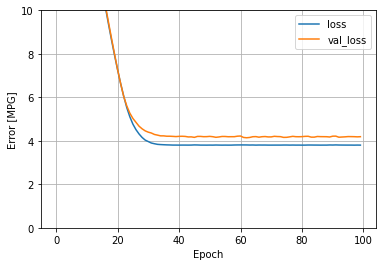

In [60]:
plot_loss(history)

* Collect the results on the test set for later:

In [61]:
test_results = {}
test_results['horsepower_model'] = horsepower_model.evaluate(test_features['Horsepower'],test_labels, verbose=0)
test_results

{'horsepower_model': 3.655156135559082}

In [ ]:
horsepower_model.predict()

* Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [62]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [63]:
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

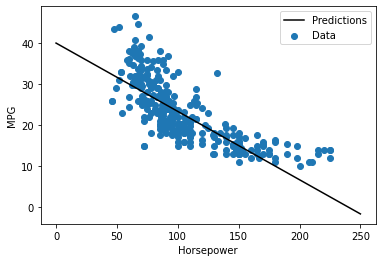

In [64]:
plot_horsepower(x, y)

## Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same  y=mx+b  except that  m  is a matrix and  b  is a vector.

Create a two-step Keras Sequential model again with the first layer being normalizer (tf.keras.layers.Normalization(axis=-1)) you defined earlier and adapted to the whole dataset:

In [65]:
linear_model = tf.keras.Sequential([normalizer,layers.Dense(units=1)])

In [67]:
train_features[:10]

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
257,6,232.0,90.0,3210.0,17.2,78,0,0,1
310,4,89.0,60.0,1968.0,18.8,80,0,1,0
328,4,146.0,67.0,3250.0,21.8,80,1,0,0
125,6,198.0,95.0,3102.0,16.5,74,0,0,1
108,4,97.0,88.0,2279.0,19.0,73,0,1,0


In [66]:
linear_model.predict(train_features[:10]) # call Model.predict on a batch of inputs, it produces units=1 outputs for each example:

array([[ 1.448],
       [-0.168],
       [-1.218],
       [ 0.017],
       [-1.177],
       [-0.476],
       [-1.007],
       [ 1.844],
       [ 0.317],
       [-0.193]], dtype=float32)

* When you call the model, its weight matrices will be built—check that the kernel weights (the  m  in  y=mx+b ) have a shape of (9, 1):

In [68]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.294],
       [-0.017],
       [-0.673],
       [-0.312],
       [-0.072],
       [-0.75 ],
       [ 0.667],
       [-0.714],
       [-0.17 ]], dtype=float32)>

In [70]:
# Configure the model with Keras Model.compile and train with Model.fit for 100 epochs:

linear_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error')


In [71]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,    # Suppress logging.
    verbose=0,     # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 8.91 s


* Using all the inputs in this regression model achieves a much lower training and validation error than the horsepower_model, which had one input:

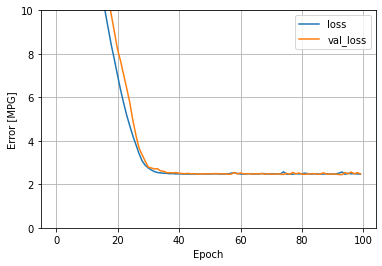

In [72]:
plot_loss(history)

In [73]:
test_results['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=0)
test_results

{'horsepower_model': 3.655156135559082, 'linear_model': 2.468278408050537}

# Regression with a deep neural network (DNN)